ФОРМУЛИРОВКА ЗАДАНИЯ

Задание 3. Python
3.1 Задача

1.Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.

2.Реализуйте функцию, которая будет строить графики по получаемым метрикам.

ПОНИМАНИЕ ЗАДАЧИ:

1.Согласно условию дано взять дополнительный файл с пользователями разделенными на две группы теста groups_add и используя дополнительные параметры посчитать метрики: в данной задачи мне как исполнителю было понятна задача следующим образом - взять таблицу с пользователями из таблицы groups далее прибавить к ней новые данные по groups_add здесь у нас получается новая таблица groups_main об этом судит условие (заголовки могут отличаться), далее в понимании дополнительных параметров было решено использовать дополнительную информацию из таблиц active_studs где хранится информация кто зашел на платформу в день теста по пользователям из groups_main и дополнительные параметры из таблицы checks где хранится инофрмация об оплатах на платформе в день теста. Не указав какие именно метрики подсчитывать в моем понимании было решено подсчитывать основные продуктовые метрики unit экономики которые мы сможем подсчитать используя данные из таблицы active_studs и таблицы checks.

2.Согласно условию необходимо было использовав метрики из первой функции сделать графики по ним: опять таки не было сказано какого типа графики необходимы, поэтому мной было принято решение строить графики воронки используя метрики конверсии и количество пользователей на шагах воронки (были сделаны несколько разных вариантов воронки: по двум разным видам на каждую группу и один график с двумя воронками по двум группам) и также были построены график сравнения выручки и график сравнения платежей по двум группам.

/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

Загружаем библиотеки

In [1]:
import pandas as pd 
import numpy as np 
import requests 
import seaborn as sns
from urllib.parse import urlencode 
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import plotly.express as px
from plotly import graph_objects as go

Записываем в переменные пути к файлам

In [2]:
groups_url = 'https://disk.yandex.ru/d/UhyYx41rTt3clQ'
groups_add_url = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'
active_studs_url = 'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'
checks_url = 'https://disk.yandex.ru/d/pH1q-VqcxXjsVA'

/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

Метрики подсчитанные в данном задании:
   1. 'count_selected_for_the_test' - количество пользователей выбранных для тестирования
   2. 'count_came_on_the_day_of_the_test' - количество пользователей зашедших в день теста на платформу из тех кто выбран для тестирования
   3. 'count_used_the_payment_mechanism' - количество пользователей кто воспользовался механизмом оплаты из тех кто зашел в день теста на платформу
   4. 'CR_select/came' - конверсия (в абсолютных значениях) из выбранных для теста в тех кто зашел на платформу в день теста
   5. 'CR_select/came_%' - конверсия (в %) из выбранных для теста в тех кто зашел на платформу в день теста
   6. 'CR_came/used_pay_mech' - конверсия (в абсолютных значениях) из тех кто зашел на платформу в день теста в тех кто воспользовался механизмом оплаты
   7. 'CR_came/used_pay_mech_%' - конверсия (в %) тех кто зашел на платформу в день теста в тех кто воспользовался механизмом оплаты
   8. 'CR_select/used_pay_mech' - конверсия (в абсолютных значениях) из выбранных для теста в тех кто воспользовался механизмом оплаты
   9. 'CR_select/used_pay_mech_%' - конверсия (в %) из выбранных для теста в тех кто воспользовался механизмом оплаты
   10. 'revenue' - выручка
   11. 'MaxPrice' - максимальный чек
   12. 'MinPrice' - минимальный чек
   13. 'number_of_purchases' - количество покупок
   14. 'APC' - количество повторных покупок на клиента
   15. 'Avg_Price' - средний чек 
   16. 'ARPPU' - средний платеж на всех платящих пользователей
   17. 'ARPU' - средний платеж на всех зашедших на платформу пользователей
    
1. Метрики количества пользователей подсчитывались как уникальные пользователи в данном шаге воронки
2. Метрики конверсии подсчитывались как отношения количества пользователей следующего шага к количеству пользователей предыдущего шага (результат выраженный в % подсчитывался как конверсия в абсолютных значениях домноженная на 100)
3. Метрики максимального, минимального чека и выручка подсчитывались как максимальное, минимальное значение чеков и сумма чеков
4. Метрика количества покупок подсчитывались как количество чеков
5. Метрика средний чек считалась как выручка / число покупок
6. Метрика количество повторных покупок на клиента считалась как количество покупок / количество пользователей кто воспользовался механизмом оплаты
7. Метрика ARPPU расчитывалась как ARPPU = Число повторных покупок * Средний чек
8. Метрика ARPU расчитывалась как ARPU = конверсия (в абсолютных значениях) из тех кто зашел на платформу в день теста в тех кто воспользовался механизмом оплаты * ARPPU

Все метрики посчитанны по группам теста A и B, находятся в колонке 'grp'

Все подсчитанные метрики располагаются в выходном из функции дата фрейме metrics

Создаем функцию, которая будет автоматически подгружать информацию из дополнительного файла (пути к файлам находятся выше) и на основании дополнительных параметров пересчитывать метрики

In [3]:
def create_metrics(groups_url, groups_add_url, active_studs_url, checks_url):
    def get_data1(groups_url):
        # Загружаем таблицу с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа), для этого используем Api
        # используем api 
        base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
        public_key = groups_url

        # получаем url 
        final_url = base_url + urlencode(dict(public_key=public_key)) 
        response = requests.get(final_url) 
        download_url = response.json()['href'] 

        # загружаем файл в df 
        download_response = requests.get(download_url) 
        groups = pd.read_csv(download_url, sep = ';')
        return groups
    groups = get_data1(groups_url)
    
    def get_data2(groups_add_url):
        # Далее загружаем таблицу с пользователями, который прислали спустя 2 дня после передачи данных, для этого используем Api
        # используем api 
        base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
        public_key = groups_add_url 

        # получаем url 
        final_url = base_url + urlencode(dict(public_key=public_key)) 
        response = requests.get(final_url) 
        download_url = response.json()['href'] 

        # загружаем файл в df 
        download_response = requests.get(download_url) 
        groups_add = pd.read_csv(download_url) 
        return groups_add
    groups_add = get_data2(groups_add_url)
    
    def get_data3(active_studs_url):
        # Далее загружаем таблицу с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента, для этого используем Api
        # используем api 
        base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
        public_key = active_studs_url

        # получаем url 
        final_url = base_url + urlencode(dict(public_key=public_key)) 
        response = requests.get(final_url) 
        download_url = response.json()['href'] 

        # загружаем файл в df 
        download_response = requests.get(download_url) 
        active_studs = pd.read_csv(download_url)
        return active_studs
    active_studs = get_data3(active_studs_url)
    
    def get_data4(checks_url):
        # Далее загружаем таблицу с информацией об оплатах пользователей в дни проведения эксперимента, для этого используем Api
        # используем api 
        base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
        public_key = checks_url 

        # получаем url 
        final_url = base_url + urlencode(dict(public_key=public_key)) 
        response = requests.get(final_url) 
        download_url = response.json()['href'] 

        # загружаем файл в df 
        download_response = requests.get(download_url) 
        checks = pd.read_csv(download_url, sep = ';')
        return checks
    checks = get_data4(checks_url)

    #обьединяем данные по пользователям об их принадлежности к контрольной и тестовой группе     
    groups_main = groups.append(groups_add, ignore_index = True)
    
    #считаем первую метрику:
    #используя обьединенные данные по пользователям об их принадлежности к контрольной и тестовой группе находим количество пользователей выбранных для а/б теста в каждой группе     
    selected_for_the_test = groups_main.groupby('grp', as_index = False).agg({'id': pd.Series.nunique})
    #переименовываем колонку с id на количество пользователей выбранных для теста      
    selected_for_the_test = selected_for_the_test.rename(columns={"id": "count_selected_for_the_test"})
    
    #в таблице (данные по пользователям об их принадлежности к контрольной и тестовой группе) переименовываем колонку id на student_id для дальнейшего склеивания с другими таблицами     
    groups_main = groups_main.rename(columns={"id": "student_id"})
    
    #обьединяем таблицу (данные по пользователям об их принадлежности к контрольной и тестовой группе) и таблицу (с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента), таким образом получаем таблицу main_df в которой осталисись только данные данные по пользователям, которые заходили в день теста на платформу из чесла все пользователей участвовавших в тесте            
    main_df = active_studs.merge(groups_main, on='student_id', how='left')
    
    #считаем вторую метрику
    #используя таблицу main_df посчитаем количество пользователей кто зашел на платформу для каждой группы теста     
    came_on_the_day_of_the_test = main_df.groupby('grp', as_index = False).agg({'student_id': pd.Series.nunique})
    #переименовываем колонку с student_id на количество пользователей зашедших на платформу    
    came_on_the_day_of_the_test = came_on_the_day_of_the_test.rename(columns={"student_id": "count_came_on_the_day_of_the_test"})
    
    #дополняем main_df данными об информацией об оплатах пользователей в дни проведения эксперимента путем обьединения с третьей таблицей checks, таким образом появится информация об оплате в день теста напротив каждого пользователя 
    main_df = main_df.merge(checks, on='student_id', how='left')
    
    #считаем третью метрику:
    #заполняем колонку с выручкой у каждого клиента нулями     
    used_the_payment_mechanism = main_df.fillna(0)
    #далее отфильтровав нулевую выручку посчитаем количество пользователей совершивших оплату     
    used_the_payment_mechanism = used_the_payment_mechanism.query("rev > 0").groupby('grp', as_index = False).agg({'student_id': pd.Series.nunique})
    #переменовываем колонку student_id на количество пользователей использовавших механизм оплаты (совершивших оплату)
    used_the_payment_mechanism = used_the_payment_mechanism.rename(columns={"student_id": "count_used_the_payment_mechanism"})
    
    #собираем воронку:
    # обьединяем данные по количеству пользователей выбранных для теста и данные по количеству зашедших на платформу в день теста пользователей     
    funnel = selected_for_the_test.merge(came_on_the_day_of_the_test, on='grp', how='inner')
    # обьединяем таблицу funnel и данные по количеству использовавших механизм оплаты (совершивших оплату)   
    funnel = funnel.merge(used_the_payment_mechanism, on='grp', how='inner')
    
    #считаем 4 и 5 и 6 метрики в двух видах:
    #добавляем к таблице воронка новую колонку в которой посчитаем конверсию из выбранных для теста в тех кто зашел на платформу в день теста     
    funnel['CR_select/came'] = funnel.count_came_on_the_day_of_the_test / funnel.count_selected_for_the_test
    #добавляем к таблице воронка новую колонку в которой посчитаем конверсию из выбранных для теста в тех кто зашел на платформу в день теста (в виде %)
    funnel['CR_select/came_%'] = (funnel.count_came_on_the_day_of_the_test / funnel.count_selected_for_the_test) * 100
    #добавляем к таблице воронка новую колонку в которой посчитаем конверсию из кто зашел на платформу в день теста в тех кто воспользовался механизмом оплаты 
    funnel['CR_came/used_pay_mech'] = funnel.count_used_the_payment_mechanism / funnel.count_came_on_the_day_of_the_test
    #добавляем к таблице воронка новую колонку в которой посчитаем конверсию из кто зашел на платформу в день теста в тех кто воспользовался механизмом оплаты (в виде %)
    funnel['CR_came/used_pay_mech_%'] = (funnel.count_used_the_payment_mechanism / funnel.count_came_on_the_day_of_the_test) * 100
    #добавляем к таблице воронка новую колонку в которой посчитаем конверсию из выбранных для теста в тех кто воспользовался механизмом оплаты 
    funnel['CR_select/used_pay_mech'] = funnel.count_used_the_payment_mechanism / funnel.count_selected_for_the_test
    #добавляем к таблице воронка новую колонку в которой посчитаем конверсию из выбранных для теста в тех кто воспользовался механизмом оплаты (в виде %)
    funnel['CR_select/used_pay_mech_%'] = (funnel.count_used_the_payment_mechanism / funnel.count_selected_for_the_test) * 100
    
    #считаем 7 метрику:
    #используя таблицу main_df находим выручку полученную с пользователей в каждой группе теста
    SumRevenue = main_df.groupby('grp', as_index = False).agg({'rev':'sum'})
    #переименовываем колонку rev в выручку (revenue)
    SumRevenue = SumRevenue.rename(columns={"rev": "revenue"})
    
    #считаем 8 метрику:
    #используя таблицу main_df находим максимальный чек в каждой группе теста
    max_Price = main_df.groupby('grp', as_index = False).agg({'rev':'max'})
    #переименовываем колонку rev в максимальный чек (MaxPrice)
    max_Price = max_Price.rename(columns={"rev": "MaxPrice"})
    
    #считаем 9 метрику:
    #используя таблицу main_df находим минимальный чек в каждой группе теста
    min_Price = main_df.groupby('grp', as_index = False).agg({'rev':'min'})
    #переименовываем колонку rev в минимальный чек (MinPrice)
    min_Price = min_Price.rename(columns={"rev": "MinPrice"})
    
    #считаем 10 метрику:
    #заполняем в таблице main_df данные выручки нулями     
    number_of_purchases = main_df.fillna(0)
    #отфильтровав нули находим количество покупок на каждую группу теста     
    number_of_purchases = number_of_purchases.query("rev > 0").groupby('grp', as_index = False).agg({'student_id': 'count'})
    #переименовываем колонку student_id на количество покупок
    number_of_purchases = number_of_purchases.rename(columns={"student_id": "number_of_purchases"})
    
    #добавляем к данным воронки данные метрик 7-10 и назовем таблицу воронки с метриками таблицей metrics    
    metrics = funnel.merge(SumRevenue, on='grp', how='inner')
    metrics = metrics.merge(max_Price, on='grp', how='inner')
    metrics = metrics.merge(min_Price, on='grp', how='inner')
    metrics = metrics.merge(number_of_purchases, on='grp', how='inner')
    
    #считаем метрики 11, 12 и 13:     
    #в таблице metrics добавляем колонку APC туда посчитаем повторные покупки по каждой группе теста      
    metrics['APC'] = metrics.number_of_purchases / metrics.count_used_the_payment_mechanism
    #в таблице metrics добавляем колонку Avg_Price туда посчитаем средний чек по каждой группе теста
    metrics['Avg_Price'] = metrics.revenue / metrics.number_of_purchases
    #в таблице metrics добавляем колонку ARPPU туда посчитаем средний платеж на всех платящих пользователей по каждой группе теста
    metrics['ARPPU'] = metrics.APC * metrics.Avg_Price
    
    #считаем метрику 14:     
    #в таблице metrics добавляем колонку ARPU туда посчитаем средний платеж на всех зашедших в день теста пользователей по каждой группе теста
    metrics['ARPU'] = metrics['CR_came/used_pay_mech'] * metrics.ARPPU
    
    return metrics

/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

In [4]:
# применяя функцию записываем ее в переменную metrics
metrics = create_metrics(groups_url, groups_add_url, active_studs_url, checks_url)

In [5]:
# выводим получившийся датафрейм с подсчитанными метриками
metrics

,grp,count_selected_for_the_test,count_came_on_the_day_of_the_test,count_used_the_payment_mechanism,CR_select/came,CR_select/came_%,CR_came/used_pay_mech,CR_came/used_pay_mech_%,CR_select/used_pay_mech,CR_select/used_pay_mech_%,revenue,MaxPrice,MinPrice,number_of_purchases,APC,Avg_Price,ARPPU,ARPU
0,A,14693,1538,78,0.104676,10.467570,0.050715,5.071521,0.005309,0.530865,72820.0000,3660.0,199.0,78,1.0,933.589744,933.589744,47.347204
1,B,59883,6803,314,0.113605,11.360486,0.046156,4.615611,0.005244,0.524356,394974.0035,4650.0,199.0,314,1.0,1257.878992,1257.878992,58.058798


In [6]:
# проверяем не потеряны ли у нас метрики по размеру таблицы: (1 колонка это группа в тесте, далее колонки с метриками)
print(metrics.shape)
print(metrics.columns)

(2, 18)
Index(['grp', 'count_selected_for_the_test',
       'count_came_on_the_day_of_the_test', 'count_used_the_payment_mechanism',
       'CR_select/came', 'CR_select/came_%', 'CR_came/used_pay_mech',
       'CR_came/used_pay_mech_%', 'CR_select/used_pay_mech',
       'CR_select/used_pay_mech_%', 'revenue', 'MaxPrice', 'MinPrice',
       'number_of_purchases', 'APC', 'Avg_Price', 'ARPPU', 'ARPU'],
      dtype='object')


/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

Графики которые построены:
    1. 'Graph_1' - График сравнения двух групп по выручке (метрики количество покупок, сумма выручки)
    2. 'Graph_2' - График сравнения двух групп по платежам (метрики мин, макс, сред, ARPPU, ARPU)
    3. 'Graph_3' - График воронки контрольной группы, вариант 1 (метрики количество пользователей по шагам воронки)
    4. 'Graph_4' - График воронки контрольной группы, вариант 2 (метрики количество пользователей по шагам воронки)
    5. 'Graph_5' - График воронки контрольной группы, вариант 1 (метрики количество пользователей по шагам воронки)
    6. 'Graph_6' - График воронки контрольной группы, вариант 2 (метрики количество пользователей по шагам воронки)
    7. 'Graph_7' - График воронки обеих групп (метрики количество пользователей по шагам воронки, конверсия в %)

Данные графики были выбраны изходя из имеющихся метрик, подсчитанных в первой функции create_metrics()

Создаем функцию, которая будет строить графики по получаемым метрикам

In [10]:
def metrics_visualisation(metrics, graph_type):
    #создаем условия таким образом чтобы передавая на вход номер графика выдавал соответствующих график     
    if graph_type == 'Graph_1':
        #задаем размеры графика         
        plt.figure(figsize = (14,7))
        
        #строим график с помощью библиотеки seaborn        
        ax = sns.barplot (x='grp', y='revenue', hue = 'number_of_purchases', data = metrics)
        
        #задаем параметры подписи значений выручки         
        for g in ax.patches:
            ax.annotate(format(g.get_height(), '.1f'),
                           (g.get_x() + g.get_width() / 2., g.get_height()),
                           ha = 'center', va = 'center',
                           xytext = (0, 9),
                           textcoords = 'offset points')
        
        # Добавляем подписи к осям и легенду, заголовок графика
        plt.xlabel('Группы теста', size = 14)
        plt.ylabel('Сумма выручки', size = 14)
        plt.title('Выручка полученная с клиентов в каждой группе теста', size = 20)
        plt.legend(title = 'Сколько сделано покупок для получения выручки в группе')
        
        #выводим на показ         
        plt.show()
        
    elif graph_type == 'Graph_2':
        #выносим из таблиц metrics значения необходимые для построения графика         
        a1 = metrics.MinPrice.values [0]
        b1 = metrics.MinPrice.values [1]
        a2 = metrics.MaxPrice.values [0]
        b2 = metrics.MaxPrice.values [1]
        a3 = metrics.Avg_Price.values [0]
        a3 = a3.round(2)
        b3 = metrics.Avg_Price.values [1]
        b3 = b3.round(2)
        a4 = metrics.ARPU.values [0]
        a4 = a4.round(2)
        b4 = metrics.ARPU.values [1]
        b4 = b4.round(2)
        a5 = metrics.ARPPU.values [0]
        a5 = a5.round(2)
        b5 = metrics.ARPPU.values [1]
        b5 = b5.round(2)
        
        #задаем размеры графика  
        plt.figure(figsize = (20,10))
        
        # Данные для первой группы
        min_price_A = a1
        ARPU_A = a4
        ARPPU_A = a5
        avg_price_A = a3
        max_price_A = a2
        
        # Данные для второй группы
        min_price_B = b1
        ARPU_B = b4
        ARPPU_B = b5
        avg_price_B = b3
        max_price_B = b2
        
        # Создаем списки с данными для построения графика
        prices = ['Минимальный чек','ARPU', 'ARPPU', 'Средний чек' ,'Максимальный чек']
        group1_values = [min_price_A, ARPU_A, ARPPU_A, avg_price_A, max_price_A]
        group2_values = [min_price_B, ARPU_B, ARPPU_B, avg_price_B, max_price_B]

        # Строим график с помощью библиотеки тatplotlib
        plt.scatter(prices, group1_values, label='Группа А')
        plt.scatter(prices, group2_values, label='Группа В')

        # Добавляем подписи к точкам
        for i, value in enumerate(group1_values):
            plt.annotate(value, (prices[i], value), xytext=(-37, -10), textcoords='offset points')
        for i, value in enumerate(group2_values):
            plt.annotate(value, (prices[i], value), xytext=(5, 0), textcoords='offset points')

        # Добавляем подписи к осям и заголовок графика
        plt.xlabel('Цены', size = 14)
        plt.ylabel('Значения платежа', size = 14)
        plt.title('Сравнение двух групп по платежам', size = 20)

        # Добавляем легенду
        plt.legend(title = 'Цвет группы в тесте')

        # Отображаем график
        plt.show()
        
    elif graph_type == 'Graph_3':
        #выносим из таблиц metrics значения необходимые для построения графика
        x1 = metrics.count_selected_for_the_test.values [0]
        y1 = metrics.count_selected_for_the_test.values [1]
        x2 = metrics.count_came_on_the_day_of_the_test.values [0]
        y2 = metrics.count_came_on_the_day_of_the_test.values [1]
        x3 = metrics.count_used_the_payment_mechanism.values [0]
        y3 = metrics.count_used_the_payment_mechanism.values [1]
        
        # Создаем списки с данными для построения графика
        labels = ["Выбраны для теста", "Зашли в день теста", "Использовались механизмом оплаты"]
        count = [x1, x2, x3]
        
        #добавляем списки в датафрейм для дальнейшего построения графика
        dataf = pd.DataFrame({"labels":labels, "count":count})
        
        #задаем размеры графика
        plt.figure(figsize = (14,7))
        
        # Строим график с помощью библиотеки seaborn
        ax = sns.barplot(x = "labels", y = "count", data=dataf)
        
        # Добавляем подписи к данным
        for g in ax.patches:
            ax.annotate(format(g.get_height(), '.1f'),
                           (g.get_x() + g.get_width() / 2., g.get_height()),
                           ha = 'center', va = 'center',
                           xytext = (0, 10),
                           textcoords = 'offset points')
            
        # Добавляем подписи к осям и заголовок графика    
        plt.xlabel('Шаг воронки', size = 14)
        plt.ylabel('Количество пользователей на шаге (человек)', size = 14)
        plt.title('Воронка пользователей от выбора для теста до покупки', size = 20)
        
        # Отображаем график
        plt.show()    
        
    elif graph_type == 'Graph_4':
        #выносим из таблиц metrics значения необходимые для построения графика
        x1 = metrics.count_selected_for_the_test.values [0]
        y1 = metrics.count_selected_for_the_test.values [1]
        x2 = metrics.count_came_on_the_day_of_the_test.values [0]
        y2 = metrics.count_came_on_the_day_of_the_test.values [1]
        x3 = metrics.count_used_the_payment_mechanism.values [0]
        y3 = metrics.count_used_the_payment_mechanism.values [1]
        
        #задаем размеры графика  
        plt.figure(figsize = (14,7))
        
        # Создаем списки с данными для построения графика
        labels = ["Выбраны для теста", "Зашли в день теста", "Использовались механизмом оплаты"]
        count = [y1, y2, y3]
        
        #добавляем списки в датафрейм для дальнейшего построения графика
        dataf = pd.DataFrame({"labels":labels, "count":count})
        
        #задаем размеры графика
        plt.figure(figsize = (9, 7))
        
        # Строим график с помощью библиотеки seaborn
        ax = sns.barplot(x = "labels", y = "count", data=dataf)
        
        # Добавляем подписи к данным
        for g in ax.patches:
            ax.annotate(format(g.get_height(), '.1f'),
                           (g.get_x() + g.get_width() / 2., g.get_height()),
                           ha = 'center', va = 'center',
                           xytext = (0, 10),
                           textcoords = 'offset points')
            
        # Добавляем подписи к осям и заголовок графика 
        plt.xlabel('Шаг воронки', size = 14)
        plt.ylabel('Количество пользователей на шаге (человек)', size = 14)
        plt.title('Воронка пользователей от выбора для теста до покупки', size = 20)
        
        # Отображаем график
        plt.show()
        
    elif graph_type == 'Graph_5':
        #выносим из таблиц metrics значения необходимые для построения графика
        x1 = metrics.count_selected_for_the_test.values [0]
        y1 = metrics.count_selected_for_the_test.values [1]
        x2 = metrics.count_came_on_the_day_of_the_test.values [0]
        y2 = metrics.count_came_on_the_day_of_the_test.values [1]
        x3 = metrics.count_used_the_payment_mechanism.values [0]
        y3 = metrics.count_used_the_payment_mechanism.values [1]
        
        # Создаем данными для построения графика
        data = dict(
            Количество_пользователей=[x1, x2, x3],
            Шаги_воронки=["Выбраны для теста", "Зашли в день теста", "Использовались механизмом оплаты"])
        
        # Строим график с помощью библиотеки plotly
        fig = px.funnel(data, x='Количество_пользователей', y='Шаги_воронки', title='Воронка пользователей от выбора для теста до покупки', width=800, height=1000)
        
        # Отображаем график
        fig.show()
        
    elif graph_type == 'Graph_6':
        #выносим из таблиц metrics значения необходимые для построения графика
        x1 = metrics.count_selected_for_the_test.values [0]
        y1 = metrics.count_selected_for_the_test.values [1]
        x2 = metrics.count_came_on_the_day_of_the_test.values [0]
        y2 = metrics.count_came_on_the_day_of_the_test.values [1]
        x3 = metrics.count_used_the_payment_mechanism.values [0]
        y3 = metrics.count_used_the_payment_mechanism.values [1]
        
        # Создаем данными для построения графика
        data = dict(
            Количество_пользователей=[y1, y2, y3],
            Шаги_воронки=["Выбраны для теста", "Зашли в день теста", "Использовались механизмом оплаты"])
        
        # Строим график с помощью библиотеки plotly
        fig = px.funnel(data, x='Количество_пользователей', y='Шаги_воронки', title='Воронка пользователей от выбора для теста до покупки', width=800, height=1000)
        
        # Отображаем график
        fig.show()
        
    elif graph_type == 'Graph_7':
        #выносим из таблиц metrics значения необходимые для построения графика
        x1 = metrics.count_selected_for_the_test.values [0]
        y1 = metrics.count_selected_for_the_test.values [1]
        x2 = metrics.count_came_on_the_day_of_the_test.values [0]
        y2 = metrics.count_came_on_the_day_of_the_test.values [1]
        x3 = metrics.count_used_the_payment_mechanism.values [0]
        y3 = metrics.count_used_the_payment_mechanism.values [1]
        
        #создаем график воронки с помощью библиотеки plotly         
        fig = go.Figure()
        
        #добавляем данные по группе А         
        fig.add_trace(go.Funnel(
            name = 'Группа А',
            y = ["Выбраны для теста", "Зашли в день теста", "Использовались механизмом оплаты"],
            x = [x1, x2, x3],
            textposition = "inside",
            textinfo = "value+percent previous"))
        
        #добавляем данные по группе B
        fig.add_trace(go.Funnel(
            name = 'Группа В',
            orientation = "h",
            y = ["Выбраны для теста", "Зашли в день теста", "Использовались механизмом оплаты"],
            x = [y1, y2, y3],
            textposition = "inside",
            textinfo = "value+percent previous"))
        
        #прописываем настройки подписей осей, название легенды, графика и размеры графика         
        fig.update_layout(
            autosize=False,
            width=1000,
            height=1000,
            title='Воронка пользователей от выбора для теста до покупки',
            xaxis_title="X Axis Title",
            yaxis_title="Шаги воронки",
            legend_title="Группа А/Б теста"
            )
        
        # Отображаем график
        fig.show()
    
    #прописываем окончательное действие что если на вход подан неправильный тип графика то вернуть ошибку о неправильном типе графика
    else:
        print('Invalid graph type')
        return
    
    # Отображаем график из общей функции
    plt.show()

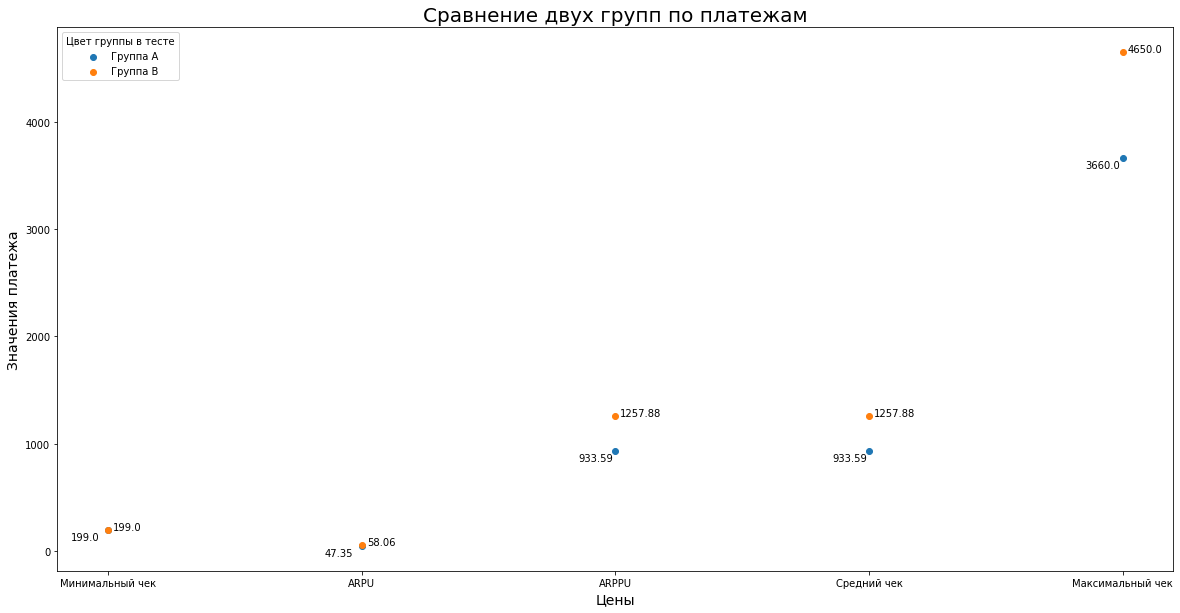

In [11]:
# выводим на показ один из желаемых графиков используя на вход данные метрик и номер желаемого графика
metrics_visualisation(metrics, 'Graph_2')